In [1]:
# Pipeline Execution Notebook
# Title
# ------
# This Jupyter Notebook demonstrates how to execute a data processing pipeline for astronomical observations.

# Subtitle
# --------
# The pipeline consists of several steps, including rebinning, calibration, subtraction, application of calibration, and imaging.



In [1]:
import time
import logging
from s3path import S3Path
from steps.rebinning import RebinningStep
from steps.agg_cal import CalibrationSubstractionApplyCalibrationStep
from steps.imaging import ImagingStep

# Set up logging
log_format = "%(asctime)s [%(levelname)s] %(filename)s:%(lineno)d -- %(message)s"
logging.basicConfig(level=logging.INFO, format=log_format, datefmt="%Y-%m-%d %H:%M:%S")
logger = logging.getLogger(__name__)


MB = 1024 ** 2
func_limit = 5

In [3]:
rebinning_params = {
        "input_data_path": S3Path("/ayman-extract/partitions/partitions_7900_60zip"),
        "parameters": {
            "flagrebin": {
                "steps": "[aoflag, avg, count]",
                "aoflag.type": "aoflagger",
                "aoflag.strategy": S3Path(
                    "/ayman-extract/parameters/rebinning/STEP1-NenuFAR64C1S.lua"
                ),
                "avg.type": "averager",
                "avg.freqstep": 4,
                "avg.timestep": 8,
            }
        },
        "output": S3Path("/ayman-extract/extract-data/rebinning_out/"),
}


start_time = time.time()
rebinning_step = RebinningStep(
    input_data_path=rebinning_params["input_data_path"],
    parameters=rebinning_params["parameters"],
    output=rebinning_params["output"]
)
finished_job = rebinning_step.run(func_limit=func_limit)
end_time = time.time()
rebinning_time = end_time - start_time
logger.info(f"Rebinning completed in {end_time - start_time} seconds.")

2024-04-12 09:43:33,380 [INFO] config.py:139 -- Lithops v3.1.2 - Python3.10
2024-04-12 09:43:33,395 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-12 09:43:33,424 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-04-12 09:43:33,439 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-12 09:43:33,480 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-12 09:43:33,492 [INFO] invokers.py:107 -- ExecutorID 4cdc3d-1 | JobID M000 - Selected Runtime: docker.io/ayman321/extract3 - 4000MB
2024-04-12 09:43:34,438 [INFO] invokers.py:172 -- ExecutorID 4cdc3d-1 | JobID M000 - Starting function invocation: _execute_step() - Total: 5 activations
2024-04-12 09:43:34,529 [INFO] invokers.py:208 -- ExecutorID 4cdc3d-1 | JobID M000 - View execution logs at /tmp/lithops-ayman/logs/4cdc3d-1-M000.log
2024-04-12 09:43:34,531 [INFO] executors.py:491 -- ExecutorID 4cdc3d-1 - Get

In [5]:

calibration_params = {
    
    
        "cal": {
            "msin": "",
            "msin.datacolumn": "DATA",
            "msout": ".",
            "steps": "[cal]",
            "cal.type": "ddecal",
            "cal.mode": "diagonal",
            "cal.sourcedb": S3Path(
                "/ayman-extract/parameters/calibration/STEP2A-apparent.sourcedb"
            ),
            "cal.h5parm": "",
            "cal.solint": 4,
            "cal.nchan": 4,
            "cal.maxiter": 50,
            "cal.uvlambdamin": 5,
            "cal.smoothnessconstraint": 2e6,
        }
}
substraction_params = {
    "input_data_path": calibration_params["output"],
    "parameters": {
        "sub": {
            "msin": "",
            "msin.datacolumn": "DATA",
            "msout": ".",
            "msout.datacolumn": "SUBTRACTED_DATA",
            "steps": "[sub]",
            "sub.type": "h5parmpredict",
            "sub.sourcedb": S3Path(
                "/ayman-extract/parameters/calibration/STEP2A-apparent.sourcedb"
            ),
            "sub.directions": "[[CygA],[CasA]]",
            "sub.operation": "subtract",
            "sub.applycal.parmdb": "",
            "sub.applycal.steps": "[sub_apply_amp,sub_apply_phase]",
            "sub.applycal.correction": "fulljones",
            "sub.applycal.sub_apply_amp.correction": "amplitude000",
            "sub.applycal.sub_apply_phase.correction": "phase000",
        }
    },
    "output": S3Path("/ayman-extract/extract-data/substraction_out/"),
}
applycal_params = {
    "input_data_path": substraction_params["output"],
    "parameters": {
        "apply": {
            "msin": "",
            "msin.datacolumn": "SUBTRACTED_DATA",
            "msout": ".",
            "msout.datacolumn": "CORRECTED_DATA",
            "steps": "[apply]",
            "apply.type": "applycal",
            "apply.steps": "[apply_amp,apply_phase]",
            "apply.apply_amp.correction": "amplitude000",
            "apply.apply_phase.correction": "phase000",
            "apply.direction": "[Main]",
            "apply.parmdb": "",
        }
    },
    "output": S3Path("/ayman-extract/extract-data/applycal_out/"),
}
start_time = time.time()

finished_job = CalibrationSubstractionApplyCalibrationStep(
    input_data_path=calibration_params["input_data_path"],
    parameters=[
        calibration_params["parameters"],
        substraction_params["parameters"],
        applycal_params["parameters"],
    ],
    output=applycal_params["output"],
).run(func_limit=5)
end_time = time.time()

calibration_time = end_time - start_time
logger.info(f"Calibration, substraction, and apply calibration completed in {calibration_time} seconds.")


2024-04-09 08:24:49,252 [INFO] config.py:139 -- Lithops v3.1.2 - Python3.10


2024-04-09 08:24:49,271 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-09 08:24:49,310 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-04-09 08:24:49,328 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-09 08:24:49,359 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-09 08:24:49,373 [INFO] invokers.py:107 -- ExecutorID 2b7fa7-2 | JobID M000 - Selected Runtime: docker.io/ayman321/extract3 - 4000MB
2024-04-09 08:24:50,159 [INFO] invokers.py:172 -- ExecutorID 2b7fa7-2 | JobID M000 - Starting function invocation: _execute_step() - Total: 5 activations
2024-04-09 08:24:53,122 [INFO] invokers.py:208 -- ExecutorID 2b7fa7-2 | JobID M000 - View execution logs at /tmp/lithops-ayman/logs/2b7fa7-2-M000.log
2024-04-09 08:24:53,124 [INFO] executors.py:491 -- ExecutorID 2b7fa7-2 - Getting results from 5 function activations
2024-04-09 08:24:53,125 [INFO] wait

In [6]:



imaging_params = {
    "input_data_path": applycal_params["output"],
    "output_path": S3Path("/ayman-extract/extract-data/imaging_out/"),
}

start_time = time.time()
finished_job = ImagingStep(
    input_data_path=imaging_params["input_data_path"],
    parameters="",
    output=imaging_params["output_path"],
).run()


end_time = time.time()

imaging_time = end_time - start_time
logger.info(f"Imaging completed in {imaging_time} seconds.")

2024-04-09 08:27:25,090 [INFO] config.py:139 -- Lithops v3.1.2 - Python3.10
2024-04-09 08:27:25,109 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-09 08:27:25,145 [INFO] k8s.py:111 -- Kubernetes client created - Namespace: default
2024-04-09 08:27:25,160 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-09 08:27:25,191 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000
2024-04-09 08:27:25,204 [INFO] invokers.py:107 -- ExecutorID 2b7fa7-3 | JobID A000 - Selected Runtime: docker.io/ayman321/extract3 - 2000MB
2024-04-09 08:27:25,883 [INFO] invokers.py:172 -- ExecutorID 2b7fa7-3 | JobID A000 - Starting function invocation: _execute_step() - Total: 1 activations
2024-04-09 08:27:25,964 [INFO] invokers.py:208 -- ExecutorID 2b7fa7-3 | JobID A000 - View execution logs at /tmp/lithops-ayman/logs/2b7fa7-3-A000.log
2024-04-09 08:27:25 [INFO] imaging.py:192 -- parameters: 
2024-04-09 08:27:2

In [7]:
import lithops

# fits image is stored at:
bucket = 'ayman-extract'
key = 'extract-data/imaging_out/Cygloop-205-210-b0-1024-image.fits'
file_name = 'image.fits'

# Download the file from the storage backend
lithops.Storage().download_file(bucket, key, file_name)


2024-04-09 08:29:03,304 [INFO] minio.py:61 -- MinIO client created - Endpoint: http://192.168.5.24:9000


True

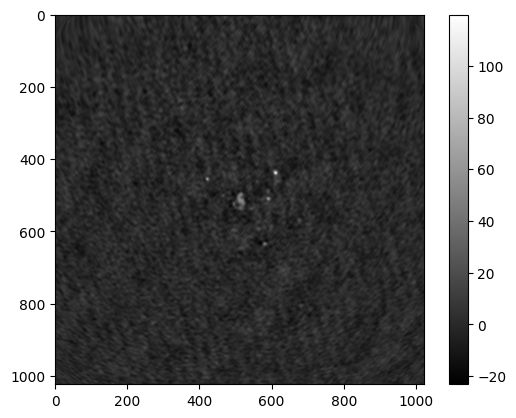

In [8]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Specify the path to the .fits file
fits_file_path = 'image.fits'

# Open the .fits file
image_data = fits.getdata(fits_file_path)

# Adjust the image_data to reduce its dimensionality to 2D
image_data_2d = image_data[0, 0, :, :]

# Now use plt.imshow on the 2D image data
plt.imshow(image_data_2d, cmap='gray')
plt.colorbar()
plt.show()


In [9]:
logger.info("Pipeline execution completed.")
logger.info(f"Total execution time: {rebinning_time +calibration_time + imaging_time} seconds.")
logger.info(f"Rebinning time: {rebinning_time} seconds.")
logger.info(f"Calibration time: {calibration_time} seconds.")
logger.info(f"Imaging time: {imaging_time} seconds.")

2024-04-09 08:29:24 [INFO] 2051606163.py:1 -- Pipeline execution completed.
2024-04-09 08:29:24 [INFO] 2051606163.py:2 -- Total execution time: 113.97543382644653 seconds.
2024-04-09 08:29:24 [INFO] 2051606163.py:3 -- Rebinning time: 21.948192596435547 seconds.
2024-04-09 08:29:24 [INFO] 2051606163.py:4 -- Calibration time: 62.08881592750549 seconds.
2024-04-09 08:29:24 [INFO] 2051606163.py:5 -- Imaging time: 29.938425302505493 seconds.
